# M6 with Transformer-based MIL Framework 

## Multiple Instance Learning with Transformer Architecture

This notebook implements an **improved Transformer-based Multiple Instance Learning (MIL)** approach for m6A modification detection:

- **Each site is a "bag"** containing multiple "instances" (reads)
- **Bag label**: 1 if modified (m6A present), 0 if unmodified
- **Instance labels**: Unknown (we don't know which specific reads show modification)
- **MIL assumption**: A bag is positive if at least one instance is positive


### Transformer Architecture

The improved Transformer model uses:
- **Multi-head self-attention**: Learns relationships between all reads in a bag (order-independent)
- **NO position encoding**: Reads are treated as an unordered set
- **Attention masking**: Padded positions are properly masked out
- **Multi-head attention pooling**: Learnable queries extract bag-level representation
- **Feed-forward networks**: Non-linear transformations
- **Layer normalization**: Training stability

### Key Advantages

- **Permutation invariant**: Order doesn't matter (biologically appropriate)
- **Uses more reads**: 50 vs 20 = 2.5x more information per site
- **Honest padding**: Zero-padding with masks instead of artificial duplication
- **More training data**: Lower minimum threshold (15 reads) includes more sites
- Captures complex dependencies between reads
- Parallel processing of all instances
- Multi-head attention provides rich interpretability
- More robust and generalizable predictions


## 1. Import Libraries

In [24]:
import pandas as pd
import numpy as np
import gzip
import json
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu124
CUDA available: True


## 2. Configuration

Define all hyperparameters and settings for the Transformer model

In [ ]:
class Config:
    """Configuration for Transformer-based MIL m6A detection"""
    
    # Data parameters
    N_READS_PER_SITE = 50  # Max reads per bag (sequence length) - INCREASED from 20
    MIN_READS_THRESHOLD = 15  # Minimum reads required to include site - NEW
    INPUT_DIM = 9
    USE_PADDING = True  # Use zero-padding with attention masking - NEW
    
    # Transformer architecture
    EMBED_DIM = 128  # Embedding dimension (d_model)
    NUM_HEADS = 4  # Number of attention heads in transformer
    NUM_LAYERS = 5  # Number of transformer layers
    FF_DIM = 256  # Feed-forward network dimension
    DROPOUT = 0.3
    
    # Multi-head attention pooling
    POOLING_HEADS = 4  # Number of learnable query vectors for pooling
    
    # Training parameters
    BATCH_SIZE = 32  # REDUCED from 64 due to larger sequence length
    EPOCHS = 50
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    
    # Focal Loss for imbalanced data
    USE_FOCAL_LOSS = True
    FOCAL_ALPHA = 0.75
    FOCAL_GAMMA = 2.0
    
    # Training optimization
    MIXED_PRECISION = True
    GRADIENT_CLIP = 1.0
    NUM_WORKERS = 0
    
    # Early stopping
    PATIENCE = 15
    
    # Permutation augmentation
    USE_PERMUTATION_AUG = True  # Randomly permute read order during training
    
    # Data split ratios (by gene_id)
    TRAIN_RATIO = 0.7
    VALID_RATIO = 0.15
    TEST_RATIO = 0.15
    
    # Paths
    DATA_FILE = '../data/dataset0.json.gz'
    LABELS_FILE = '../data/data.info.labelled'
    OUTPUT_DIR = 'results_transformer'
    CHECKPOINT_DIR = 'checkpoints_transformer_padded'
    
    LOG_INTERVAL = 10

config = Config()
print("Configuration loaded successfully")
print(f"Transformer config: {config.NUM_LAYERS} layers, {config.NUM_HEADS} heads, embed_dim={config.EMBED_DIM}")
print(f"Multi-head attention pooling: {config.POOLING_HEADS} query heads")
print(f"Permutation augmentation: {config.USE_PERMUTATION_AUG}")
print(f"NO positional encoding - permutation invariant design")
print(f"\n✓ NEW: Using {config.N_READS_PER_SITE} reads per site (up from 20)")
print(f"✓ NEW: Minimum {config.MIN_READS_THRESHOLD} reads required")
print(f"✓ NEW: Zero-padding with attention masking enabled")

Configuration loaded successfully
Transformer config: 5 layers, 4 heads, embed_dim=128
Multi-head attention pooling: 4 query heads
Permutation augmentation: True
NO positional encoding - permutation invariant design

✓ NEW: Using 50 reads per site (up from 20)
✓ NEW: Minimum 15 reads required
✓ NEW: Zero-padding with attention masking enabled


## 3. Loss Function

Focal Loss handles class imbalance by down-weighting easy examples

In [26]:
class MultiHeadAttentionPooling(nn.Module):
    """
    Multi-head attention pooling for permutation-invariant aggregation
    
    Uses multiple learnable queries to extract different aspects of the bag,
    then combines them for the final bag representation.
    
    NOW SUPPORTS ATTENTION MASKING for padded positions.
    """
    
    def __init__(self, d_model, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # Learnable query vectors (one per head)
        self.queries = nn.Parameter(torch.randn(num_heads, d_model))
        
        # Multi-head attention
        self.attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        # Combine multiple heads
        self.combine = nn.Sequential(
            nn.Linear(d_model * num_heads, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    
    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: (batch_size, n_instances, d_model)
            key_padding_mask: (batch_size, n_instances) - True for padding, False for real data
        Returns:
            bag_repr: (batch_size, d_model)
            attention_weights: (batch_size, num_heads, n_instances)
        """
        batch_size, n_instances, d_model = x.shape
        
        # Expand queries for batch
        queries = self.queries.unsqueeze(0).expand(batch_size, -1, -1)  # (batch_size, num_heads, d_model)
        
        # Apply multi-head attention with masking
        # key_padding_mask: True means ignore (padding), False means attend (real data)
        attn_output, attn_weights = self.attention(
            queries, x, x, 
            key_padding_mask=key_padding_mask,
            average_attn_weights=False
        )  # attn_output: (batch_size, num_heads, d_model)
           # attn_weights: (batch_size, num_heads, num_heads, n_instances)
        
        # Extract attention weights (from queries to instances)
        # Shape: (batch_size, num_heads, n_instances)
        attn_weights = attn_weights.mean(dim=2)  # Average over query heads
        
        # Flatten heads and combine
        attn_output_flat = attn_output.reshape(batch_size, -1)  # (batch_size, num_heads * d_model)
        bag_repr = self.combine(attn_output_flat)  # (batch_size, d_model)
        
        return bag_repr, attn_weights


def focal_loss_with_logits(logits, targets, alpha=0.75, gamma=2.0):
    """
    Focal Loss for imbalanced classification (works with logits)
    Safe for autocast/mixed precision training
    
    Args:
        logits: Model predictions (raw logits)
        targets: Ground truth labels
        alpha: Weighting factor for positive class
        gamma: Focusing parameter (higher = more focus on hard examples)
    """
    BCE_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt = torch.exp(-BCE_loss)
    
    # Focal term
    focal_term = (1 - pt) ** gamma
    
    # Alpha balancing
    alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    
    F_loss = alpha_t * focal_term * BCE_loss
    
    return F_loss.mean()

## 5. Transformer MIL Model (Permutation-Invariant)

Architecture Overview:

1. **Input Embedding**: Projects 9D features to embedding dimension
2. **NO Positional Encoding**: Removed for permutation invariance
3. **Transformer Encoder**: Multi-head self-attention + FFN layers
4. **Multi-Head Attention Pooling**: Learnable queries extract multiple aspects
5. **Classifier**: Predicts bag-level label



In [28]:
class TransformerMIL(nn.Module):
    """
    Transformer-based Multiple Instance Learning (Permutation-Invariant)
    
    Uses self-attention to model relationships between instances (reads) in a bag.
    NO positional encoding - designed for unordered sets of reads.
    
    NOW SUPPORTS ATTENTION MASKING for padded positions.
    """
    
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        
        # Input embedding
        self.input_projection = nn.Sequential(
            nn.Linear(config.INPUT_DIM, config.EMBED_DIM),
            nn.LayerNorm(config.EMBED_DIM),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT)
        )
        
        # NO POSITIONAL ENCODING - reads have no meaningful order
        # Transformer will learn relationships without position bias
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.EMBED_DIM,
            nhead=config.NUM_HEADS,
            dim_feedforward=config.FF_DIM,
            dropout=config.DROPOUT,
            batch_first=True,
            norm_first=True  # Pre-normalization for better training
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=config.NUM_LAYERS
        )
        
        # Multi-head attention pooling for permutation-invariant aggregation
        self.attention_pool = MultiHeadAttentionPooling(
            d_model=config.EMBED_DIM,
            num_heads=config.POOLING_HEADS,
            dropout=config.DROPOUT
        )
        
        # Bag-level classifier
        self.classifier = nn.Sequential(
            nn.Linear(config.EMBED_DIM, config.EMBED_DIM // 2),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.EMBED_DIM // 2, 1)
        )
    
    def forward(self, x, src_key_padding_mask=None):
        """
        Args:
            x: (batch_size, n_instances, input_dim)
            src_key_padding_mask: (batch_size, n_instances) - True for padding, False for real data
        Returns:
            bag_logits: (batch_size,)
            attention_weights: (batch_size, num_heads, n_instances)
        """
        batch_size, n_instances, _ = x.shape
        
        # Project input to embedding dimension
        x = self.input_projection(x)  # (batch_size, n_instances, embed_dim)
        
        # NO positional encoding added here
        
        # Transformer encoder with attention masking
        # src_key_padding_mask: True = ignore (padding), False = attend (real data)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)  # (batch_size, n_instances, embed_dim)
        
        # Multi-head attention pooling to get bag representation (with masking)
        bag_repr, attention_weights = self.attention_pool(x, key_padding_mask=src_key_padding_mask)  # (batch_size, embed_dim)
        
        # Classify
        bag_logits = self.classifier(bag_repr).squeeze(-1)  # (batch_size,)
        
        return bag_logits, attention_weights
    
    def calculate_objective(self, x, bag_labels, mask=None):
        """Calculate MIL objective with optional masking"""
        bag_logits, attention_weights = self(x, src_key_padding_mask=mask)
        
        if self.config.USE_FOCAL_LOSS:
            loss = focal_loss_with_logits(
                bag_logits, bag_labels,
                alpha=self.config.FOCAL_ALPHA,
                gamma=self.config.FOCAL_GAMMA
            )
        else:
            loss = F.binary_cross_entropy_with_logits(bag_logits, bag_labels)
        
        return loss, bag_logits, attention_weights

print("Transformer MIL model defined (permutation-invariant with padding support)")

Transformer MIL model defined (permutation-invariant with padding support)


## 6. Data Loading

Load the m6A dataset from compressed JSON format

In [29]:
def load_data(data_file, labels_file):
    """Load dataset"""
    print("Loading dataset...")
    rows = []
    
    with gzip.open(data_file, 'rt', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)
    
    with gzip.open(data_file, 'rt', encoding='utf-8') as f:
        for line in tqdm(f, total=total_lines, desc="Loading data"):
            data = json.loads(line)
            for transcript_id, positions in data.items():
                for transcript_position, sequences in positions.items():
                    for sequence, feature_list in sequences.items():
                        for features in feature_list:
                            rows.append({
                                'transcript_id': transcript_id,
                                'transcript_position': int(transcript_position),
                                'dwell_-1': features[0],
                                'std_-1': features[1],
                                'mean_-1': features[2],
                                'dwell_0': features[3],
                                'std_0': features[4],
                                'mean_0': features[5],
                                'dwell_+1': features[6],
                                'std_+1': features[7],
                                'mean_+1': features[8],
                            })
    
    df = pd.DataFrame(rows)
    labels = pd.read_csv(labels_file)
    
    print(f"Loaded {len(df)} reads from {len(df.groupby(['transcript_id', 'transcript_position']))} sites")
    return df, labels

# Load data
df, labels = load_data(config.DATA_FILE, config.LABELS_FILE)
print(f"\nData shape: {df.shape}")
print(f"Labels shape: {labels.shape}")
print(f"\nFirst few rows:")
df.head()

Loading dataset...


Loading data: 100%|██████████| 121838/121838 [00:16<00:00, 7522.45it/s]


Loaded 11027106 reads from 121838 sites

Data shape: (11027106, 11)
Labels shape: (121838, 4)

First few rows:


,transcript_id,transcript_position,dwell_-1,std_-1,mean_-1,dwell_0,std_0,mean_0,dwell_+1,std_+1,mean_+1
0,ENST00000000233,244,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1
1,ENST00000000233,244,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9
2,ENST00000000233,244,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6
3,ENST00000000233,244,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4
4,ENST00000000233,244,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2


## 7. MIL Dataset Class (with Permutation Augmentation)

Each sample is a "bag" containing multiple instances (reads).
Training uses permutation augmentation to ensure the model learns permutation-invariant features.

In [30]:
class MILDataset(Dataset):
    """
    Dataset for Multiple Instance Learning
    Each sample is a bag containing multiple instances (reads)
    
    NEW: Supports zero-padding with attention masks instead of duplication.
    Includes permutation augmentation for training to ensure the model
    learns permutation-invariant representations.
    """
    
    def __init__(self, df, labels_df, config, augment=False):
        self.config = config
        self.augment = augment  # Use permutation augmentation during training
        
        # Merge with labels
        df_merged = df.merge(
            labels_df[['transcript_id', 'transcript_position', 'label', 'gene_id']],
            on=['transcript_id', 'transcript_position'], 
            how='inner'
        )
        
        self.feature_cols = ['dwell_-1', 'std_-1', 'mean_-1',
                            'dwell_0', 'std_0', 'mean_0',
                            'dwell_+1', 'std_+1', 'mean_+1']
        
        # Group by site (bag)
        self.bags = []
        self.bag_labels = []
        self.gene_ids = []
        
        grouped = df_merged.groupby(['transcript_id', 'transcript_position'])
        
        # Use MIN_READS_THRESHOLD instead of N_READS_PER_SITE for filtering
        min_threshold = config.MIN_READS_THRESHOLD if hasattr(config, 'MIN_READS_THRESHOLD') else config.N_READS_PER_SITE
        
        for (transcript_id, position), site_df in tqdm(grouped, desc="Creating MIL dataset"):
            instances = site_df[self.feature_cols].values
            
            # Accept sites with at least MIN_READS_THRESHOLD reads
            if len(instances) >= min_threshold:
                self.bags.append(instances)
                self.bag_labels.append(site_df['label'].iloc[0])
                self.gene_ids.append(site_df['gene_id'].iloc[0])
        
        self.bag_labels = np.array(self.bag_labels, dtype=np.float32)
        self.gene_ids = np.array(self.gene_ids)
        
        # Compute normalization statistics (only from real reads, not padding)
        all_instances = np.vstack(self.bags)
        self.mean = np.mean(all_instances, axis=0)
        self.std = np.std(all_instances, axis=0) + 1e-8
        
        pos_count = sum(self.bag_labels)
        print(f"MIL Dataset: {len(self.bags)} bags")
        print(f"  Positive bags: {pos_count} ({pos_count/len(self.bags)*100:.1f}%)")
        print(f"  Negative bags: {len(self.bags)-pos_count} ({(len(self.bags)-pos_count)/len(self.bags)*100:.1f}%)")
        print(f"  Min reads threshold: {min_threshold}")
        if self.augment and self.config.USE_PERMUTATION_AUG:
            print(f"  Permutation augmentation: ENABLED")
        if hasattr(self.config, 'USE_PADDING') and self.config.USE_PADDING:
            print(f"  Zero-padding with attention masking: ENABLED")
    
    def __len__(self):
        return len(self.bags)
    
    def __getitem__(self, idx):
        instances = self.bags[idx].copy()
        bag_label = self.bag_labels[idx]
        n_instances = len(instances)
        
        # NEW: Handle padding/sampling with attention masks
        if n_instances > self.config.N_READS_PER_SITE:
            # Downsample: randomly select N_READS_PER_SITE reads
            indices = np.random.choice(n_instances, self.config.N_READS_PER_SITE, replace=False)
            instances = instances[indices]
            n_real = self.config.N_READS_PER_SITE
            mask = np.zeros(self.config.N_READS_PER_SITE, dtype=bool)  # All False = all real data
            
        else:
            # Pad with zeros + create mask
            n_real = n_instances
            padding = np.zeros((self.config.N_READS_PER_SITE - n_real, self.config.INPUT_DIM))
            instances = np.vstack([instances, padding])
            # Mask: False for real data, True for padding (PyTorch convention)
            mask = np.array([False]*n_real + [True]*(self.config.N_READS_PER_SITE - n_real))
        
        # Normalize only real reads (before permutation)
        instances[:n_real] = (instances[:n_real] - self.mean) / self.std
        
        # PERMUTATION AUGMENTATION - randomly shuffle ONLY real reads
        # This prevents the model from learning position-dependent features
        if self.augment and self.config.USE_PERMUTATION_AUG and n_real > 1:
            real_indices = np.arange(n_real)
            perm = np.random.permutation(real_indices)
            instances[:n_real] = instances[perm]
            # Mask doesn't need shuffling - still first n_real are False, rest are True
        
        return torch.FloatTensor(instances), torch.FloatTensor([bag_label]), torch.BoolTensor(mask)

print("MIL Dataset class defined with zero-padding and attention masking")

MIL Dataset class defined with zero-padding and attention masking


## 8. Train/Valid/Test Split by Gene ID

Split data by gene_id to prevent data leakage

In [31]:
# Create full dataset first
full_dataset = MILDataset(df, labels, config, augment=False)

# Get unique gene IDs
unique_genes = np.unique(full_dataset.gene_ids)
np.random.seed(42)
np.random.shuffle(unique_genes)

# Split gene IDs
n_genes = len(unique_genes)
n_train = int(n_genes * config.TRAIN_RATIO)
n_valid = int(n_genes * config.VALID_RATIO)

train_genes = set(unique_genes[:n_train])
valid_genes = set(unique_genes[n_train:n_train+n_valid])
test_genes = set(unique_genes[n_train+n_valid:])

print(f"Gene split:")
print(f"  Train genes: {len(train_genes)}")
print(f"  Valid genes: {len(valid_genes)}")
print(f"  Test genes: {len(test_genes)}")

# Split bags based on gene IDs
train_idx = [i for i, gene in enumerate(full_dataset.gene_ids) if gene in train_genes]
valid_idx = [i for i, gene in enumerate(full_dataset.gene_ids) if gene in valid_genes]
test_idx = [i for i, gene in enumerate(full_dataset.gene_ids) if gene in test_genes]

print(f"\nBag split:")
print(f"  Train bags: {len(train_idx)}")
print(f"  Valid bags: {len(valid_idx)}")
print(f"  Test bags: {len(test_idx)}")

# Create split datasets
def create_subset(dataset, indices, augment=False):
    subset = MILDataset.__new__(MILDataset)
    subset.bags = [dataset.bags[i] for i in indices]
    subset.bag_labels = dataset.bag_labels[indices]
    subset.gene_ids = dataset.gene_ids[indices]
    subset.config = dataset.config
    subset.augment = augment  # Enable augmentation for training
    subset.mean = dataset.mean
    subset.std = dataset.std
    subset.feature_cols = dataset.feature_cols
    return subset

# Training set with augmentation enabled
train_dataset = create_subset(full_dataset, train_idx, augment=True)
valid_dataset = create_subset(full_dataset, valid_idx, augment=False)
test_dataset = create_subset(full_dataset, test_idx, augment=False)

print(f"\nClass distribution:")
print(f"  Train: {sum(train_dataset.bag_labels)}/{len(train_dataset.bag_labels)} positive ({sum(train_dataset.bag_labels)/len(train_dataset.bag_labels)*100:.1f}%)")
print(f"  Valid: {sum(valid_dataset.bag_labels)}/{len(valid_dataset.bag_labels)} positive ({sum(valid_dataset.bag_labels)/len(valid_dataset.bag_labels)*100:.1f}%)")
print(f"  Test: {sum(test_dataset.bag_labels)}/{len(test_dataset.bag_labels)} positive ({sum(test_dataset.bag_labels)/len(test_dataset.bag_labels)*100:.1f}%)")

print(f"\nPermutation augmentation:")
print(f"  Train: {'ENABLED' if train_dataset.augment and config.USE_PERMUTATION_AUG else 'DISABLED'}")
print(f"  Valid: {'ENABLED' if valid_dataset.augment and config.USE_PERMUTATION_AUG else 'DISABLED'}")
print(f"  Test: {'ENABLED' if test_dataset.augment and config.USE_PERMUTATION_AUG else 'DISABLED'}")

Creating MIL dataset: 100%|██████████| 121838/121838 [00:21<00:00, 5749.57it/s]


MIL Dataset: 121838 bags
  Positive bags: 5475.0 (4.5%)
  Negative bags: 116363.0 (95.5%)
  Min reads threshold: 15
  Zero-padding with attention masking: ENABLED
Gene split:
  Train genes: 2696
  Valid genes: 577
  Test genes: 579

Bag split:
  Train bags: 84887
  Valid bags: 19146
  Test bags: 17805

Class distribution:
  Train: 3815.0/84887 positive (4.5%)
  Valid: 899.0/19146 positive (4.7%)
  Test: 761.0/17805 positive (4.3%)

Permutation augmentation:
  Train: ENABLED
  Valid: DISABLED
  Test: DISABLED


## 9. Create Data Loaders

In [38]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Valid batches: {len(valid_loader)}")
print(f"  Test batches: {len(test_loader)}")

Data loaders created:
  Train batches: 2653
  Valid batches: 599
  Test batches: 557


## 10. Training Functions

In [39]:
def train_epoch(model, train_loader, optimizer, device, config, scaler=None):
    """Train for one epoch with attention masking support"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch_data in pbar:
        # Unpack batch (now includes mask)
        if len(batch_data) == 3:
            bag, bag_label, mask = batch_data
            mask = mask.to(device)
        else:
            bag, bag_label = batch_data
            mask = None
        
        bag = bag.to(device)
        bag_label = bag_label.squeeze(-1).to(device)
        
        optimizer.zero_grad()
        
        if config.MIXED_PRECISION and scaler is not None:
            with autocast():
                loss, bag_logits, _ = model.calculate_objective(bag, bag_label, mask=mask)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRADIENT_CLIP)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss, bag_logits, _ = model.calculate_objective(bag, bag_label, mask=mask)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRADIENT_CLIP)
            optimizer.step()
        
        # Convert logits to probabilities for metrics
        bag_probs = torch.sigmoid(bag_logits)
        
        total_loss += loss.item()
        all_preds.extend(bag_probs.detach().cpu().numpy())
        all_labels.extend(bag_label.detach().cpu().numpy())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    auc = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) > 1 else 0.5
    
    return avg_loss, auc


def evaluate(model, val_loader, device, config):
    """Evaluate model with attention masking support"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_attentions = []
    
    with torch.no_grad():
        for batch_data in tqdm(val_loader, desc="Evaluating",leave=False):
            # Unpack batch (now includes mask)
            if len(batch_data) == 3:
                bag, bag_label, mask = batch_data
                mask = mask.to(device)
            else:
                bag, bag_label = batch_data
                mask = None
            
            bag = bag.to(device)
            bag_label = bag_label.squeeze(-1).to(device)
            
            if config.MIXED_PRECISION:
                with autocast():
                    loss, bag_logits, attention = model.calculate_objective(bag, bag_label, mask=mask)
            else:
                loss, bag_logits, attention = model.calculate_objective(bag, bag_label, mask=mask)
            
            # Convert logits to probabilities
            bag_probs = torch.sigmoid(bag_logits)
            
            total_loss += loss.item()
            all_preds.extend(bag_probs.cpu().numpy())
            all_labels.extend(bag_label.cpu().numpy())
            
            if attention is not None:
                all_attentions.extend(attention.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    auc = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) > 1 else 0.5
    pr_auc = average_precision_score(all_labels, all_preds) if len(set(all_labels)) > 1 else 0.5
    
    # Find best threshold
    best_f1 = 0
    best_threshold = 0.5
    for thresh in np.arange(0.1, 0.9, 0.05):
        preds_binary = (np.array(all_preds) >= thresh).astype(int)
        f1 = f1_score(all_labels, preds_binary)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
    
    return avg_loss, auc, pr_auc, all_preds, all_labels, all_attentions, best_threshold, best_f1

print("Training functions defined with attention masking support")

Training functions defined with attention masking support


## 11. Initialize Model and Optimizer

In [40]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create Transformer model
model = TransformerMIL(config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel: Transformer MIL")
print(f"Total trainable parameters: {total_params:,}")
print(f"Architecture:")
print(f"  - {config.NUM_LAYERS} Transformer layers")
print(f"  - {config.NUM_HEADS} attention heads")
print(f"  - {config.EMBED_DIM} embedding dimension")
print(f"  - {config.FF_DIM} feed-forward dimension")


# Optimizer with learning rate warmup
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Mixed precision scaler
scaler = GradScaler() if config.MIXED_PRECISION else None

print(f"\nOptimizer: AdamW (lr={config.LEARNING_RATE}, weight_decay={config.WEIGHT_DECAY})")
print(f"Mixed precision: {config.MIXED_PRECISION}")

Using device: cuda

Model: Transformer MIL
Total trainable parameters: 804,737
Architecture:
  - 5 Transformer layers
  - 4 attention heads
  - 128 embedding dimension
  - 256 feed-forward dimension

Optimizer: AdamW (lr=0.0001, weight_decay=1e-05)
Mixed precision: True


## 12. Training Loop

In [41]:
# Create output directories
output_dir = Path(config.OUTPUT_DIR)
checkpoint_dir = Path(config.CHECKPOINT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Training history
history = {
    'train_loss': [],
    'train_auc': [],
    'valid_loss': [],
    'valid_auc': [],
    'valid_pr_auc': [],
    'valid_f1': []
}

# Early stopping
best_val_pr_auc = 0
patience_counter = 0

print(f"\nStarting training for {config.EPOCHS} epochs...")
print("="*100)

# Print header
print(f"{'Epoch':>6} | {'Train Loss':>11} | {'Train AUC':>10} | {'Val Loss':>11} | {'Val AUC':>10} | {'Val PR-AUC':>11} | {'Val F1':>10} | {'Status':>15}")
print("-"*100)

for epoch in range(config.EPOCHS):
    # Train
    train_loss, train_auc = train_epoch(
        model, train_loader, optimizer, device, config, scaler
    )
    
    # Validate
    val_loss, val_auc, val_pr_auc, val_preds, val_labels, val_attentions, best_thresh, best_f1 = evaluate(
        model, valid_loader, device, config
    )
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['valid_loss'].append(val_loss)
    history['valid_auc'].append(val_auc)
    history['valid_pr_auc'].append(val_pr_auc)
    history['valid_f1'].append(best_f1)
    
    # Determine status message
    status = ""
    if val_pr_auc > best_val_pr_auc:
        best_val_pr_auc = val_pr_auc
        patience_counter = 0
        torch.save(model.state_dict(), checkpoint_dir / 'best_model.pt')
        status = "✓ Best model"
    else:
        patience_counter += 1
        status = f"Patience {patience_counter}/{config.PATIENCE}"
    
    # Print row
    print(f"{epoch+1:>6} | {train_loss:>11.4f} | {train_auc:>10.4f} | {val_loss:>11.4f} | {val_auc:>10.4f} | {val_pr_auc:>11.4f} | {best_f1:>10.4f} | {status:>15}")
    
    # Early stopping check
    if patience_counter >= config.PATIENCE:
        print("-"*100)
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

print("="*100)
print(f"Training complete! Best PR-AUC: {best_val_pr_auc:.4f}")


Starting training for 50 epochs...
 Epoch |  Train Loss |  Train AUC |    Val Loss |    Val AUC |  Val PR-AUC |     Val F1 |          Status
----------------------------------------------------------------------------------------------------


     1 |      0.0212 |     0.8124 |      0.0184 |     0.8815 |      0.4378 |     0.4822 |    ✓ Best model


     2 |      0.0189 |     0.8615 |      0.0179 |     0.8877 |      0.4259 |     0.4628 |   Patience 1/15


     3 |      0.0179 |     0.8792 |      0.0175 |     0.9010 |      0.4484 |     0.4959 |    ✓ Best model


     4 |      0.0176 |     0.8856 |      0.0183 |     0.9007 |      0.4341 |     0.4576 |   Patience 1/15


     5 |      0.0171 |     0.8940 |      0.0179 |     0.9023 |      0.4602 |     0.4950 |    ✓ Best model


     6 |      0.0169 |     0.8969 |      0.0178 |     0.9016 |      0.4267 |     0.4463 |   Patience 1/15


     7 |      0.0168 |     0.8973 |      0.0172 |     0.9054 |      0.4719 |     0.4962 |    ✓ Best model


     8 |      0.0165 |     0.9018 |      0.0174 |     0.9054 |      0.4708 |     0.4776 |   Patience 1/15


     9 |      0.0165 |     0.9015 |      0.0172 |     0.9020 |      0.4241 |     0.4703 |   Patience 2/15


    10 |      0.0163 |     0.9057 |      0.0178 |     0.9057 |      0.4719 |     0.4983 |    ✓ Best model


    11 |      0.0163 |     0.9059 |      0.0172 |     0.9110 |      0.4686 |     0.4898 |   Patience 1/15


    12 |      0.0160 |     0.9107 |      0.0191 |     0.9065 |      0.4746 |     0.5050 |    ✓ Best model


    13 |      0.0160 |     0.9097 |      0.0175 |     0.9042 |      0.4636 |     0.4859 |   Patience 1/15


    14 |      0.0158 |     0.9133 |      0.0171 |     0.9135 |      0.4903 |     0.5112 |    ✓ Best model


    15 |      0.0157 |     0.9149 |      0.0165 |     0.9141 |      0.4772 |     0.5008 |   Patience 1/15


    16 |      0.0155 |     0.9161 |      0.0169 |     0.9133 |      0.4683 |     0.4916 |   Patience 2/15


    17 |      0.0155 |     0.9164 |      0.0170 |     0.9139 |      0.4775 |     0.4835 |   Patience 3/15


    18 |      0.0156 |     0.9154 |      0.0165 |     0.9148 |      0.4879 |     0.5028 |   Patience 4/15


    19 |      0.0152 |     0.9206 |      0.0179 |     0.9098 |      0.4786 |     0.4986 |   Patience 5/15


    20 |      0.0154 |     0.9177 |      0.0167 |     0.9128 |      0.4654 |     0.4934 |   Patience 6/15


    21 |      0.0152 |     0.9210 |      0.0172 |     0.9100 |      0.4845 |     0.5077 |   Patience 7/15


    22 |      0.0153 |     0.9192 |      0.0165 |     0.9180 |      0.4825 |     0.5076 |   Patience 8/15


    23 |      0.0152 |     0.9201 |      0.0168 |     0.9130 |      0.4720 |     0.4902 |   Patience 9/15


    24 |      0.0151 |     0.9219 |      0.0166 |     0.9128 |      0.4762 |     0.5088 |  Patience 10/15


    25 |      0.0151 |     0.9225 |      0.0178 |     0.9129 |      0.4876 |     0.5278 |  Patience 11/15


    26 |      0.0150 |     0.9224 |      0.0189 |     0.9123 |      0.5004 |     0.5089 |    ✓ Best model


    27 |      0.0149 |     0.9237 |      0.0179 |     0.9144 |      0.4849 |     0.5162 |   Patience 1/15


    28 |      0.0149 |     0.9243 |      0.0168 |     0.9166 |      0.4970 |     0.5088 |   Patience 2/15


    29 |      0.0150 |     0.9232 |      0.0164 |     0.9204 |      0.4952 |     0.5122 |   Patience 3/15


    30 |      0.0147 |     0.9260 |      0.0173 |     0.9170 |      0.4896 |     0.5102 |   Patience 4/15


    31 |      0.0147 |     0.9274 |      0.0188 |     0.9088 |      0.4858 |     0.5126 |   Patience 5/15


    32 |      0.0149 |     0.9240 |      0.0177 |     0.9168 |      0.4753 |     0.4910 |   Patience 6/15


    33 |      0.0147 |     0.9261 |      0.0167 |     0.9163 |      0.4987 |     0.5178 |   Patience 7/15


    34 |      0.0146 |     0.9276 |      0.0182 |     0.9092 |      0.4944 |     0.5260 |   Patience 8/15


    35 |      0.0146 |     0.9276 |      0.0176 |     0.9119 |      0.4753 |     0.5029 |   Patience 9/15


    36 |      0.0145 |     0.9297 |      0.0174 |     0.9155 |      0.4814 |     0.5073 |  Patience 10/15


    37 |      0.0146 |     0.9271 |      0.0174 |     0.9166 |      0.4763 |     0.4992 |  Patience 11/15


    38 |      0.0143 |     0.9321 |      0.0184 |     0.9103 |      0.4524 |     0.4789 |  Patience 12/15


    39 |      0.0145 |     0.9288 |      0.0174 |     0.9131 |      0.4903 |     0.4975 |  Patience 13/15


    40 |      0.0145 |     0.9288 |      0.0179 |     0.9131 |      0.4736 |     0.4971 |  Patience 14/15


    41 |      0.0145 |     0.9286 |      0.0177 |     0.9150 |      0.4612 |     0.4977 |  Patience 15/15
----------------------------------------------------------------------------------------------------
Early stopping triggered at epoch 41
Training complete! Best PR-AUC: 0.5004


## 13. Plot Training History

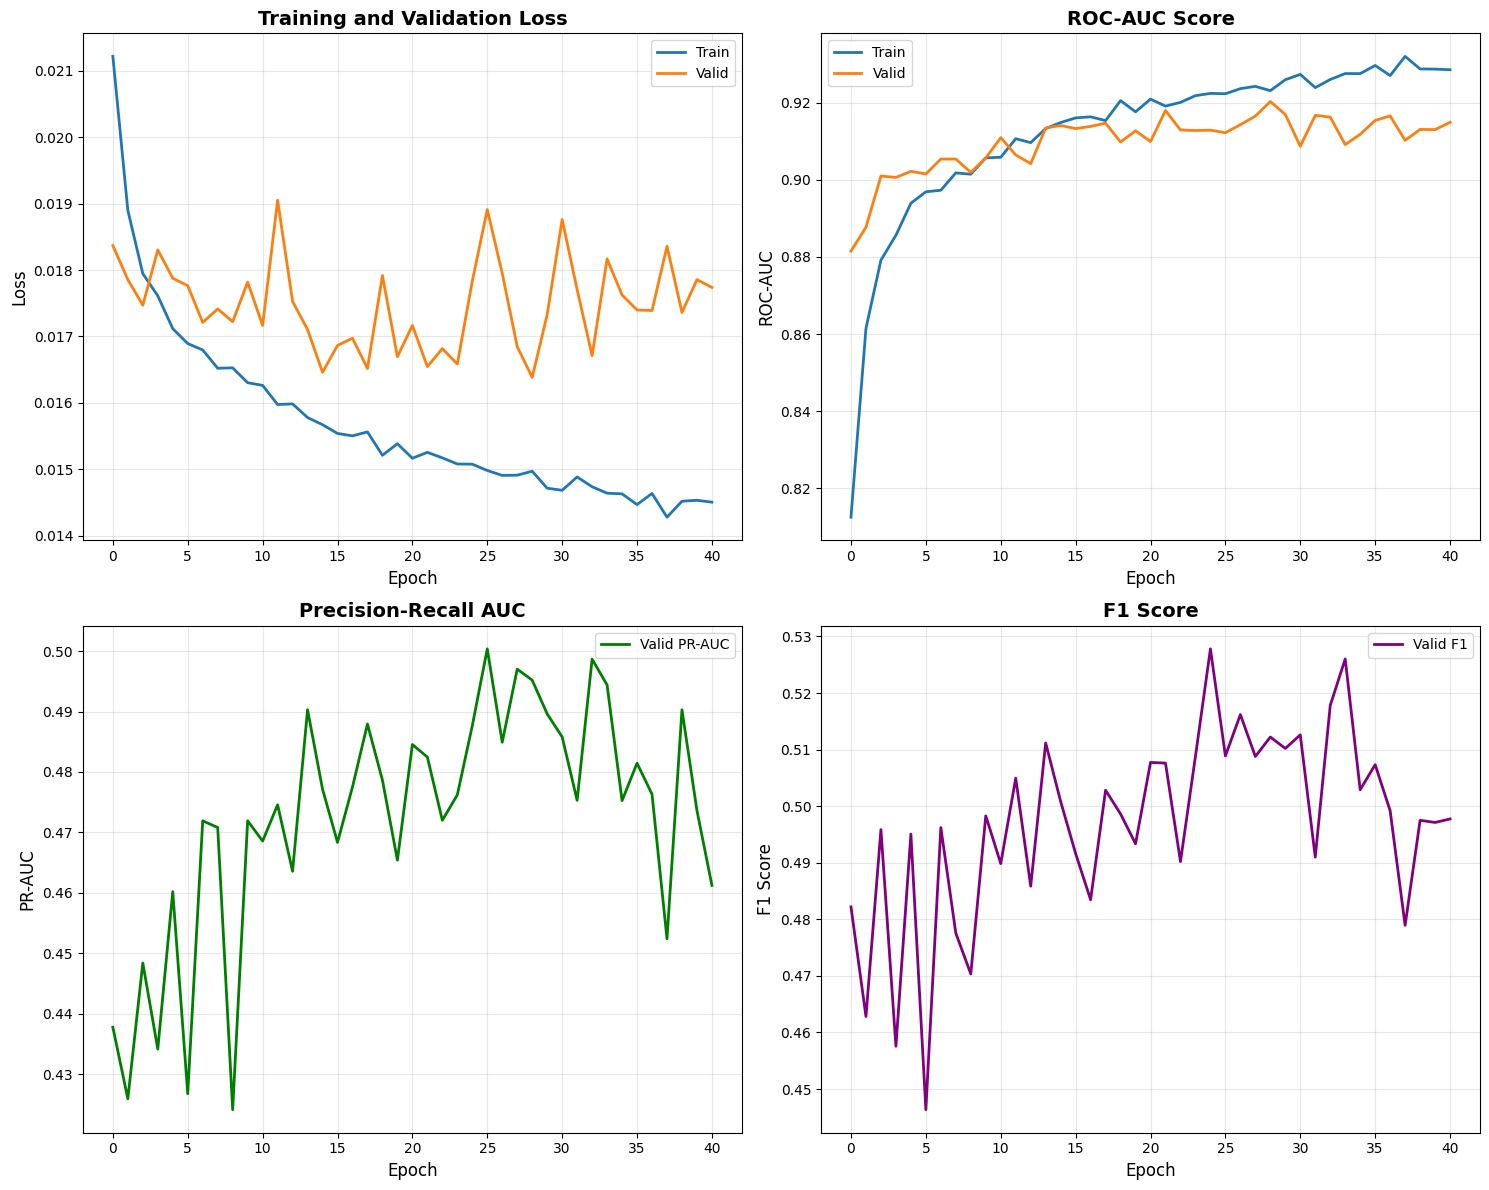

Training history plot saved to results_transformer_mil_padded\training_history.png


In [42]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['valid_loss'], label='Valid', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# AUC
axes[0, 1].plot(history['train_auc'], label='Train', linewidth=2)
axes[0, 1].plot(history['valid_auc'], label='Valid', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('ROC-AUC', fontsize=12)
axes[0, 1].set_title('ROC-AUC Score', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# PR-AUC
axes[1, 0].plot(history['valid_pr_auc'], label='Valid PR-AUC', linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('PR-AUC', fontsize=12)
axes[1, 0].set_title('Precision-Recall AUC', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# F1
axes[1, 1].plot(history['valid_f1'], label='Valid F1', linewidth=2, color='purple')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('F1 Score', fontsize=12)
axes[1, 1].set_title('F1 Score', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to {output_dir / 'training_history.png'}")

## 14. Evaluate on Test Set

In [43]:
# Load best model
model.load_state_dict(torch.load(checkpoint_dir / 'best_model.pt'))
print("Best model loaded")

# Evaluate on test set
test_loss, test_auc, test_pr_auc, test_preds, test_labels, test_attentions, test_thresh, test_f1 = evaluate(
    model, test_loader, device, config
)

print(f"\nTest Set Results:")
print("="*80)
print(f"  Loss: {test_loss:.4f}")
print(f"  ROC-AUC: {test_auc:.4f}")
print(f"  PR-AUC: {test_pr_auc:.4f}")
print(f"  Best F1: {test_f1:.4f} @ threshold {test_thresh:.3f}")
print("="*80)

Best model loaded



Test Set Results:
  Loss: 0.0183
  ROC-AUC: 0.9080
  PR-AUC: 0.4211
  Best F1: 0.4886 @ threshold 0.600


## 15. Plot ROC and PR Curves

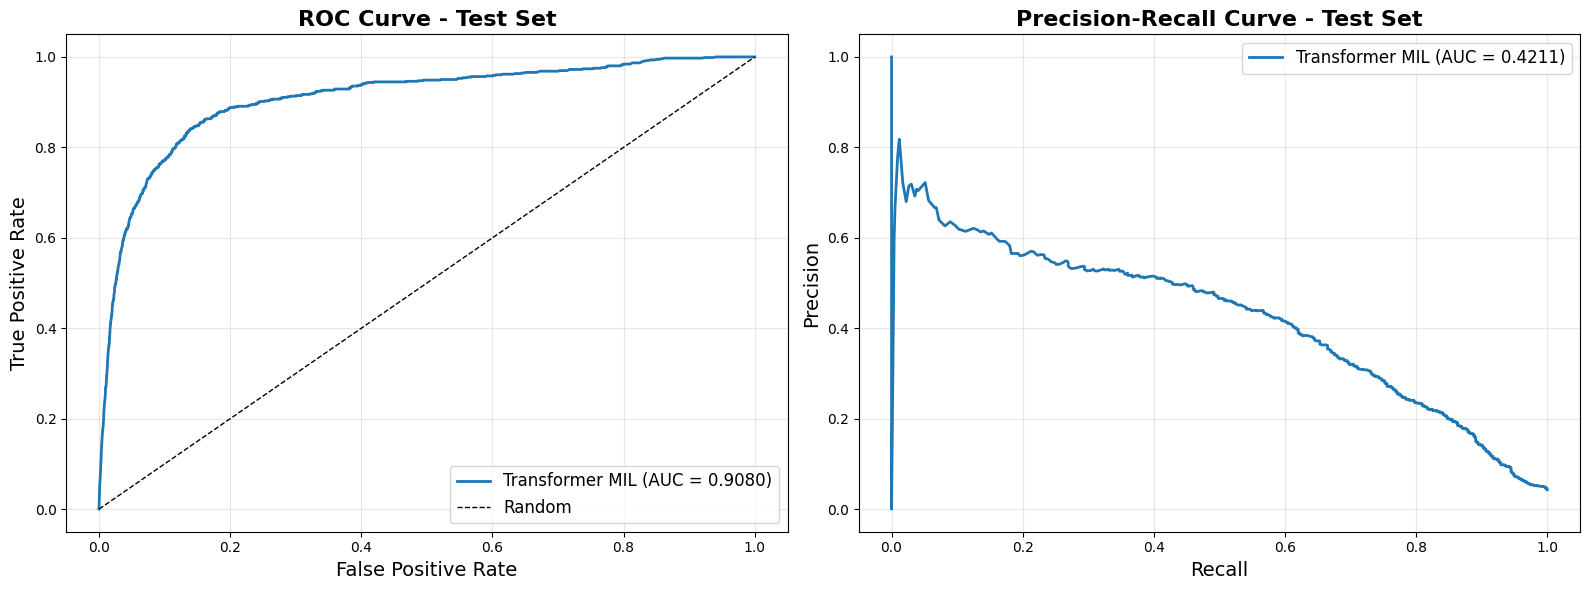

Test curves saved to results_transformer_mil_padded\test_curves.png


In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_preds)
axes[0].plot(fpr, tpr, linewidth=2, label=f'Transformer MIL (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].set_title('ROC Curve - Test Set', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# PR Curve
precision, recall, _ = precision_recall_curve(test_labels, test_preds)
axes[1].plot(recall, precision, linewidth=2, label=f'Transformer MIL (AUC = {test_pr_auc:.4f})')
axes[1].set_xlabel('Recall', fontsize=14)
axes[1].set_ylabel('Precision', fontsize=14)
axes[1].set_title('Precision-Recall Curve - Test Set', fontsize=16, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'test_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Test curves saved to {output_dir / 'test_curves.png'}")

## 17. Save Results and Predictions

In [47]:
# Save test predictions
results_df = pd.DataFrame({
    'true_label': test_labels,
    'predicted_probability': test_preds
})
results_df.to_csv(output_dir / 'test_predictions.csv', index=False)
print(f"Test predictions saved to {output_dir / 'test_predictions.csv'}")

# Save summary
summary_text = f"""M6ANET TRANSFORMER MIL RESULTS (IMPROVED - PERMUTATION INVARIANT)
{'='*80}

Model: Transformer-based MIL (Permutation-Invariant Design)
Architecture:
  - {config.NUM_LAYERS} Transformer encoder layers
  - {config.NUM_HEADS} attention heads in transformer
  - {config.POOLING_HEADS} attention heads in pooling layer
  - {config.EMBED_DIM} embedding dimension
  - {config.FF_DIM} feed-forward dimension


Permutation Invariance:
  - No positional encoding used
  - Permutation augmentation: {config.USE_PERMUTATION_AUG}
  - Random shuffling of reads during training
  - Learned relationships are order-independent

MIL Characteristics:
  - Each site is a 'bag' of reads (instances)
  - Bag is positive if at least one read shows modification
  - Transformer learns complex relationships between reads
  - Multi-head attention provides interpretability

Model Configuration:
  Dropout: {config.DROPOUT}
  Focal loss: {config.USE_FOCAL_LOSS}
  Focal alpha: {config.FOCAL_ALPHA}
  Focal gamma: {config.FOCAL_GAMMA}

Training:
  Epochs trained: {len(history['train_loss'])}
  Batch size: {config.BATCH_SIZE}
  Learning rate: {config.LEARNING_RATE}
  Weight decay: {config.WEIGHT_DECAY}
  Mixed precision: {config.MIXED_PRECISION}
  Total parameters: {total_params:,}

Data Split (by gene_id):
  Train: {len(train_dataset)} bags from {len(train_genes)} genes (with augmentation)
  Valid: {len(valid_dataset)} bags from {len(valid_genes)} genes
  Test: {len(test_dataset)} bags from {len(test_genes)} genes

Test Set Results:
  Loss: {test_loss:.4f}
  ROC-AUC: {test_auc:.4f}
  PR-AUC: {test_pr_auc:.4f}
  Best F1: {test_f1:.4f}  threshold {test_thresh:.3f}

Best Validation PR-AUC: {best_val_pr_auc:.4f}

"""

with open(output_dir / 'summary.txt', 'w') as f:
    f.write(summary_text)

print(f"\nSummary saved to {output_dir / 'summary.txt'}")
print("\n" + summary_text)

Test predictions saved to results_transformer_mil_padded\test_predictions.csv

Summary saved to results_transformer_mil_padded\summary.txt

M6ANET TRANSFORMER MIL RESULTS (IMPROVED - PERMUTATION INVARIANT)

Model: Transformer-based MIL (Permutation-Invariant Design)
Architecture:
  - 5 Transformer encoder layers
  - 4 attention heads in transformer
  - 4 attention heads in pooling layer
  - 128 embedding dimension
  - 256 feed-forward dimension


Permutation Invariance:
  - No positional encoding used
  - Permutation augmentation: True
  - Random shuffling of reads during training
  - Learned relationships are order-independent

MIL Characteristics:
  - Each site is a 'bag' of reads (instances)
  - Bag is positive if at least one read shows modification
  - Transformer learns complex relationships between reads
  - Multi-head attention provides interpretability

Model Configuration:
  Dropout: 0.3
  Focal loss: True
  Focal alpha: 0.75
  Focal gamma: 2.0

Training:
  Epochs trained: 41